# Introduction

On Aprit 28th, 2025, most of Spain, parts of Portugal and a tiny fraction of souther France suffered a major electrical blackout at 12:33 Madrid local time. The recovery process was slow and was performed in stages, first starting with the north and south of the Iberian peninsula and finally reaching all the country. The recovery process in the Madrid area was done in stages. While there are some parts that went back to normality at 21:30 local time, others were not recovered after 23:30

## STARS4ALL Infrastructure

The blackout affected the STARS4ALL photometers located in Spain and the server infrastructure. While the Grafana panel and its associated InfluxDB database services were not recovered until April, 29th 08:00, the core infrastructure (MQTT Broker, readings collector process and IDA database) hosted in the UCM datacenter was discoverd to be up and running entirely during the blackout. However, the progressive degradation of communications infrastructure finally affected this part too. Examination of server log records have determined that **the STARS4ALL unavailability period started at 14:00 local time (last MQTT message received) and ended at 21:40 local time (first MQTT activity recorded again)**

## Photometer selection

At the time of the blackout, most of the TESS-W traffic came from photometeres deployed all over the world. In particular, photometers deployed in Spain were sending saturated daylight readings, thus being discared before writting to the IDA database. From 12:33 to 14:00, the only photometer's readings being stored were of those recdoring night sky brightness all over the world.

To search candidates for this study, we will focus on photometers that:
1. had location deployment avaliable to us
2. were deployed in the Iberian peninsula (timezone=Europe/Madrid)
3. were sending data from 2025-04-28 21:40 (local time) on

The result list after database query is the following:

| name	| place	| town | # readings
|-------|-------|------| -----------
| stars1  | Coslada, barrio de La Estación | Coslada | 119
| stars7  | Pamplona Centro | Pamplona | 60
| stars17  | Palacio Viejo de las Corchuelas | Torrejón el Rubio, Cáceres | 45
| stars33  | M-30 | Madrid | 96
| stars62  | Centre d'Observació de l'Univers | Àger | 2
| stars73  | Observatorio Astronómico de San Blas | Teruel | 61
| stars75  | Valencia | Valencia | 58
| stars76  | Valencia | Valencia | 59
| stars85  | Observatorio Universidad Complutense de Madrid | Madrid | 95
| stars88  | Aula Espazio Gela | Bilbao | 60
| stars201  | Finca La Cocosa | Badajoz | 58
| stars202  | Casa Rural Cijara | Pantano de Cijara | 59
| stars272  | Asociación Daimieleña de Astronomía | Daimiel | 48
| stars495  | Centro Internacional de Innovación Deportiva El Anillo | Guijo de Granadilla | 56
| stars536  | Parque Natural de Izki | Korres | 60
| stars555  | Las Praderas | Las Praderas | 60
| stars608  | Centelles | Centelles | 60
| stars612  | Centre d'Observació de l'Univers | Àger | 60
| stars639  | AAS Carballada Ager | Ager | 60
| stars660  | Arzoz | Arzoz (Navarra) | 60
| stars714  | Institut d'Alcarràs | Alcarràs | 60
| stars746  | Observatorio JoseX | Sierra de Segura | 60
| stars747  | Escuela de Ingenierías Industriales de la Universidad de Extremadura | Badajoz | 50
| stars749  | Observatorio de la Vega del Codorno | Alto de la Vega | 60
| stars759  | Albanyà | Albanyà | 61
| stars795  | Astrolizard Observatory | Joanetes, Girona | 60
| stars831  | Observatori del Montsec | Sant Esteve de la Sarga | 49
| stars835  | Ayuntamiento | Oliva de la Frontera | 20
| stars945  | Observatorio Jardín | Aldeanueva de la Vera, Cáceres | 61
| stars1134  | Aniartea | Jungitu | 60



## Obtaining photometers data

Since the IDA files were being normally as usual, we will download the 2025-04 IDA monthly files for the selected photometers.

# stars1 analysis
This photometer, which belongs to Cristobal García, designer and manufacturer of [TESS-W photometers](https://tessskysensor.blogspot.com/) has been reliably sending data since 2019. It is located in Coslada, a town in the Madrid metropolitan area. As such, it can be a witness of the staged recovery. 

We begin by importing all the Python libraries we are going to use

In [156]:
import os
import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import ascii
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
from astropy.table import Table
from astropy.time import Time
import datetime
import matplotlib.dates as mdates
from typing import Sequence, Iterable, Tuple

Let's define some convenience functions

The function below returns a list of paths to ECSV files located under a given directory and ordered by photometer name. Additional parameters allows to whitelists/blacklist a list of photometer for interactive analysis

In [157]:
def scan_ecsv_files(root_dir: str, phot_blacklist=None, phot_whitelist=None) -> Sequence[str]:
    """Convenience function to scan ECSV files under a directory and filtering out photometers"""
    def key(path): return int(os.path.basename(path).split("_")[0][5:])
    phot_blacklist = phot_blacklist or []
    paths = sorted( (os.path.join(dirpath, fname) for dirpath, dirs, files in os.walk(root_dir) for fname in files if os.path.splitext(fname)[1] == ".ecsv"), key=key)
    if phot_whitelist:
        paths = [path for path in paths if os.path.basename(path).split("_")[0] in phot_whitelist]
    paths = [path for path in paths if os.path.basename(path).split("_")[0] not in phot_blacklist]
    return paths

Convenience functions to access embedded IDA metadata

Then we read the ECSV file as an Astropy table

In [158]:
def get_phot(table: Table) -> str:
    """Extract photometer name from Table IDA metadata"""
    return table.meta["ida"]["Instrument ID"]

In [159]:
def get_location(table: Table) -> str:
    """Extract a portion of Location metadata"""
    return table.meta["ida"]["Location name"]["place"]

In [160]:
def distance(table1: Table, table2: Table) -> float:
    """
    Compute approximate geographical distance (arc) [meters] between two photometers
    Accurate for small distances only
    """
    EARTH_RADIUS = 6371009.0  # in meters
    longitude_A = table1.meta["ida"]["Position"]["longitude"]
    latitude_A = table1.meta["ida"]["Position"]["latitude"]
    longitude_B = table2.meta["ida"]["Position"]["longitude"] 
    latitude_B = table2.meta["ida"]["Position"]["latitude"]
    delta_long = math.radians(longitude_A - longitude_B)
    delta_lat = math.radians(latitude_A - latitude_B)
    mean_lat = math.radians((latitude_A + latitude_B) / 2)
    return round(EARTH_RADIUS * math.sqrt(delta_lat**2 + (math.cos(mean_lat) * delta_long) ** 2), 0)
    

In [161]:
def distances(tables: Iterable):
    return [(t1, t2, distance(t1,t2)) for t1, t2 in itertools.combinations(tables,2)]

In [162]:
def nearby(tables: Iterable, threshold):
    def near(aTuple: Tuple[Table, Table, float]) -> bool:
        return aTuple[2] <= threshold
    return list(filter(near,  distances(tables)))
    

In [163]:
def assign_labels(tables: Sequence[Table]) -> None:
    for table in tables:
        table.meta["mpl"] = dict()
        table.meta["mpl"]["label"] = get_phot(table) + ' ' + get_location(table)

In [164]:
def assign_colors(tables: Sequence[Table], colors: Iterable, distance) -> None:
    """Assign colors to tables, making nearby photometers with the same color"""
    iter_colors = iter(colors)
    for t1, t2, _ in nearby(tables, threshold=distance):
        if t1.meta["mpl"].get("color") is None:
            t1.meta["mpl"]["color"] = next(iter_colors)
        t2.meta["mpl"]["color"] = t1.meta["mpl"]["color"]
    for table in tables:
        if table.meta["mpl"].get("color") is None:
            table.meta["mpl"]["color"] = next(iter_colors)

Lets define our working list of photometers

In [165]:
PHOT_BLACK_LIST = []
PHOT_WHITE_LIST = ["stars1", "stars51", "stars33", "stars7", "stars17", "stars73","stars62","stars66","stars52","stars9"]

In [166]:
paths = scan_ecsv_files(root_dir="ecsv", phot_blacklist=PHOT_BLACK_LIST, phot_whitelist=PHOT_WHITE_LIST)
paths

['ecsv/stars1/stars1_2025-04.ecsv',
 'ecsv/stars7/stars7_2025-04.ecsv',
 'ecsv/stars9/stars9_2025-04.ecsv',
 'ecsv/stars17/stars17_2025-04.ecsv',
 'ecsv/stars33/stars33_2025-04.ecsv',
 'ecsv/stars51/stars51_2025-04.ecsv',
 'ecsv/stars52/stars52_2025-04.ecsv',
 'ecsv/stars62/stars62_2025-04.ecsv',
 'ecsv/stars73/stars73_2025-04.ecsv']

Let's read the ECSV files and convert them into Astropy tables

In [167]:
tables = [TimeSeries.read(path, format='ascii.ecsv', delimiter=',') for path in paths]

# Plotting

## Matplotlib default settings

In [168]:
mpl.rcParams['text.usetex'] = False

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['font.size'] = 20.
plt.rcParams['lines.linewidth'] = 0.
plt.rcParams['lines.marker'] = 'o'                 # the default marker
plt.rcParams['lines.markerfacecolor'] = 'auto'        # the default marker face color
plt.rcParams['lines.markeredgecolor'] = 'auto'        # the default marker edge color
plt.rcParams['lines.markeredgewidth'] = 1.0         # the line width around the marker symbol         
plt.rcParams['lines.markersize'] = 1  # marker size, in points 
plt.rcParams['axes.linewidth'] = 4.
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['grid.linewidth'] = 1.0
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['xtick.minor.size']=4
plt.rcParams['xtick.major.size']=8
plt.rcParams['ytick.minor.size']=4
plt.rcParams['ytick.major.size']=8
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

diaFmt        = mdates.DateFormatter('%d %b')
horaFmt       = mdates.DateFormatter('%H:%M')

Let's add some plotting metadata to photometers, making sure that all nearby photometers has the same plot color

In [169]:
assign_labels(tables)
assign_colors(tables, colors, distance=10000)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif'

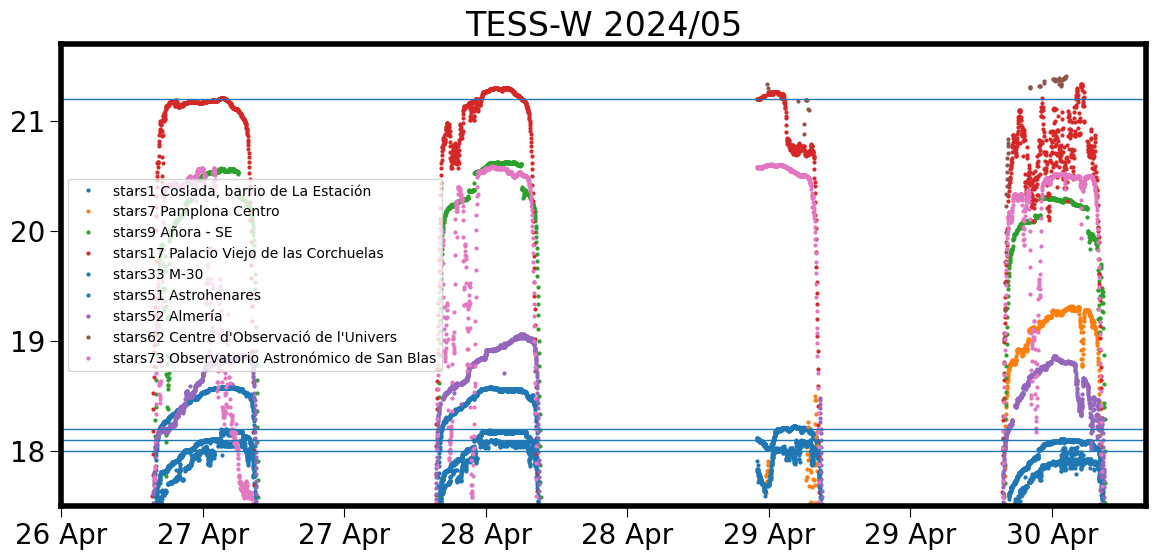

In [170]:
figure = plt.figure(figsize=(14, 6))
ax1=figure.add_subplot(111)
for table in tables:
    label = table.meta["mpl"]["label"]
    color = table.meta["mpl"]["color"]
    plt.plot(table.time.datetime,table['MSAS'], ms=2,   color=color, label=label)
plt.title('TESS-W 2024/05')
plt.xlim(datetime.datetime(2025,4,26,12,0,0),datetime.datetime(2025,4,30,8,0,0))
plt.ylim(17.5,21.7)
plt.axhline(18.0,lw=1)
plt.axhline(21.2,lw=1)
plt.axhline(18.1,lw=1)
plt.axhline(18.2,lw=1)
ax1.xaxis.set_major_formatter(diaFmt)
plt.legend(fontsize=10)
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana
findfont: Generic family 'sans-serif'

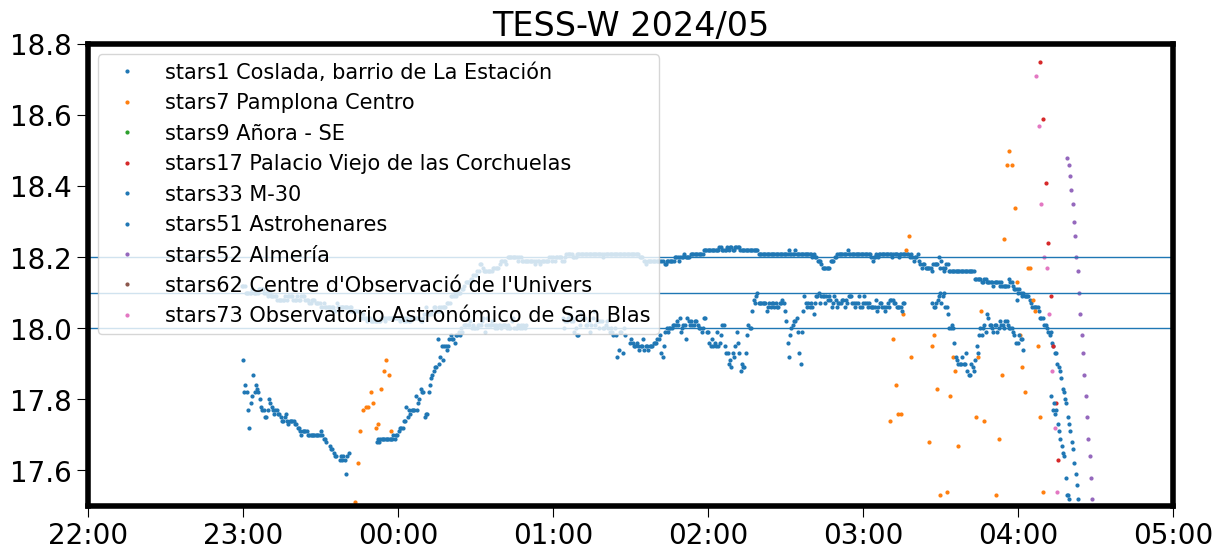

In [171]:
figure = plt.figure(figsize=(14, 6))
ax1=figure.add_subplot(111)
for table in tables:
    label = table.meta["mpl"]["label"]
    color = table.meta["mpl"]["color"]
    plt.plot(table.time.datetime,table['MSAS'], ms=2, color=color,label=label)
plt.title('TESS-W 2024/05')
plt.xlim(datetime.datetime(2025,4,28,22,0,0),datetime.datetime(2025,4,29,5,0,0))
plt.ylim(17.5,21.8)
plt.ylim(17.5,18.8)
plt.axhline(18.0,lw=1)
plt.axhline(18.1,lw=1)
plt.axhline(18.2,lw=1)
ax1.xaxis.set_major_formatter(horaFmt)
plt.legend(fontsize=15)
plt.show()